In [14]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import random
%matplotlib inline
import seaborn as sns; sns.set() # for plot styling
import numpy as np
import tarfile
from io import BytesIO
from zipfile import ZipFile
from time import time
import sklearn
from sklearn.pipeline import Pipeline
from skimage import io
from skimage.color import rgb2gray
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from matplotlib.image import imread
import glob
import random
import warnings
warnings.filterwarnings('ignore')
from PIL import Image
import mahotas.features.texture as texture

import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory

import sys
sys.path.append('C:/Users/whitm/Documents/GitHub/usd-capstone/')
sys.path.append('C:/Users/whitm/Documents/GitHub/usd-capstone/functions/')
import img_utils as aug
import resnet

In [5]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Load full data set

In [15]:
directory = "/Users/whitm/.fastai/data/food-101"
image_list = []
folder_names = []
# Get a list of all subdirectories in the given directory
subdirectories = [f.path for f in os.scandir(directory+ "/images") if f.is_dir()]

# Loop through each subdirectory
for subdirectory in subdirectories:
    # Get the folder name
    folder_name = os.path.basename(subdirectory)

    # Get a list of all image files within the subdirectory
    image_files = [f.path for f in os.scandir(subdirectory) if f.is_file() and f.name.endswith(".jpg")]

    # Loop through each image file
    for image_file in image_files:
        # Append the image file to the image_list
        image_list.append(image_file)
        folder_names.append(folder_name)

In [16]:
labels_file = directory+'/labels.txt'
with open(labels_file, 'r') as f:
    labels = [label.strip().lower().replace(' ', '_') for label in f.readlines()]

In [17]:
len(image_list)

101000

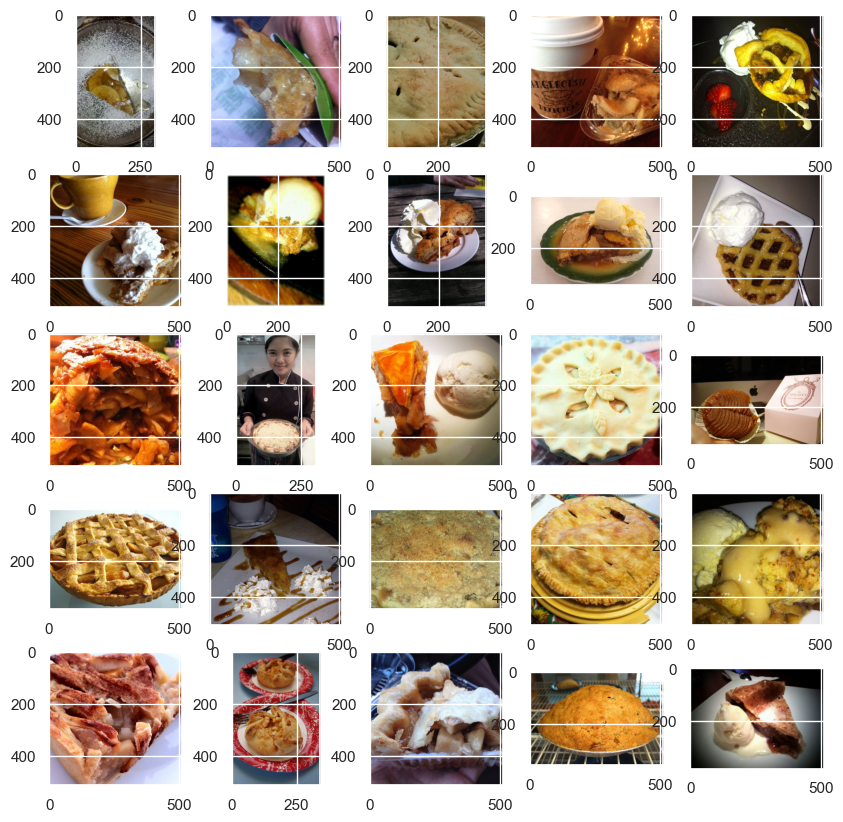

In [18]:
#plot the images
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
axes = ax.flatten()
for i in range(25):
    path=image_list[i]
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img, cmap=None)

## Train // Test Split

In [19]:
paths_names = pd.DataFrame({"path":image_list, "category": folder_names})
len(paths_names)

101000

In [20]:
train, test = train_test_split(paths_names, train_size=0.8, stratify=paths_names['category'], random_state = 33)

In [21]:
print("Train Length:", len(train))
print("Test Length:", len(test))

Train Length: 80800
Test Length: 20200


In [22]:
train.head()

path           category
85061  /Users/whitm/.fastai/data/food-101/images\samo...             samosa
41677  /Users/whitm/.fastai/data/food-101/images\fren...  french_onion_soup
27953  /Users/whitm/.fastai/data/food-101/images\crem...       creme_brulee
70047  /Users/whitm/.fastai/data/food-101/images\pad_...           pad_thai
15852  /Users/whitm/.fastai/data/food-101/images\cevi...            ceviche

### Splitting the train and test splits into their own folders for dataset creation later for modeling

In [123]:
import shutil
def creating_folders(df, destination_folder, different_split=False):
    for path in df['path']:
        folder = str(path).split("\\")[1]

        # delete path if making a new train test split
        if different_new == True:
            if os.path.exists(destination_folder):
                os.remove(destination_folder)

        # making folder if it doesn't exist
        if not os.path.exists(destination_folder + folder + "/"):
            os.makedirs(destination_folder + folder + "/")
        
        # copy images into train or test folder
        shutil.copy(path, destination_folder + folder + "/")


In [ ]:
train_destination = '/Users/whitm/.fastai/data/food-101/splits/train/'
test_destination = '/Users/whitm/.fastai/data/food-101/splits/test/'

creating_folders(test, test_destination)
creating_folders(train, train_destination)

### Observe random images from different categories

In [9]:
for _, i in train.groupby('category').apply(lambda x: x.sample(1)).iterrows():
    print(i['path'])

/Users/whitm/.fastai/data/food-101/images\apple_pie\1305678.jpg
/Users/whitm/.fastai/data/food-101/images\baby_back_ribs\3142395.jpg
/Users/whitm/.fastai/data/food-101/images\baklava\317091.jpg
/Users/whitm/.fastai/data/food-101/images\beef_carpaccio\1744294.jpg
/Users/whitm/.fastai/data/food-101/images\beef_tartare\1718378.jpg
/Users/whitm/.fastai/data/food-101/images\beet_salad\3805698.jpg
/Users/whitm/.fastai/data/food-101/images\beignets\1116735.jpg
/Users/whitm/.fastai/data/food-101/images\bibimbap\1796804.jpg
/Users/whitm/.fastai/data/food-101/images\bread_pudding\72755.jpg
/Users/whitm/.fastai/data/food-101/images\breakfast_burrito\1728490.jpg
/Users/whitm/.fastai/data/food-101/images\bruschetta\82635.jpg
/Users/whitm/.fastai/data/food-101/images\caesar_salad\372569.jpg
/Users/whitm/.fastai/data/food-101/images\cannoli\2894445.jpg
/Users/whitm/.fastai/data/food-101/images\caprese_salad\1407996.jpg
/Users/whitm/.fastai/data/food-101/images\carrot_cake\48061.jpg
/Users/whitm/.fast

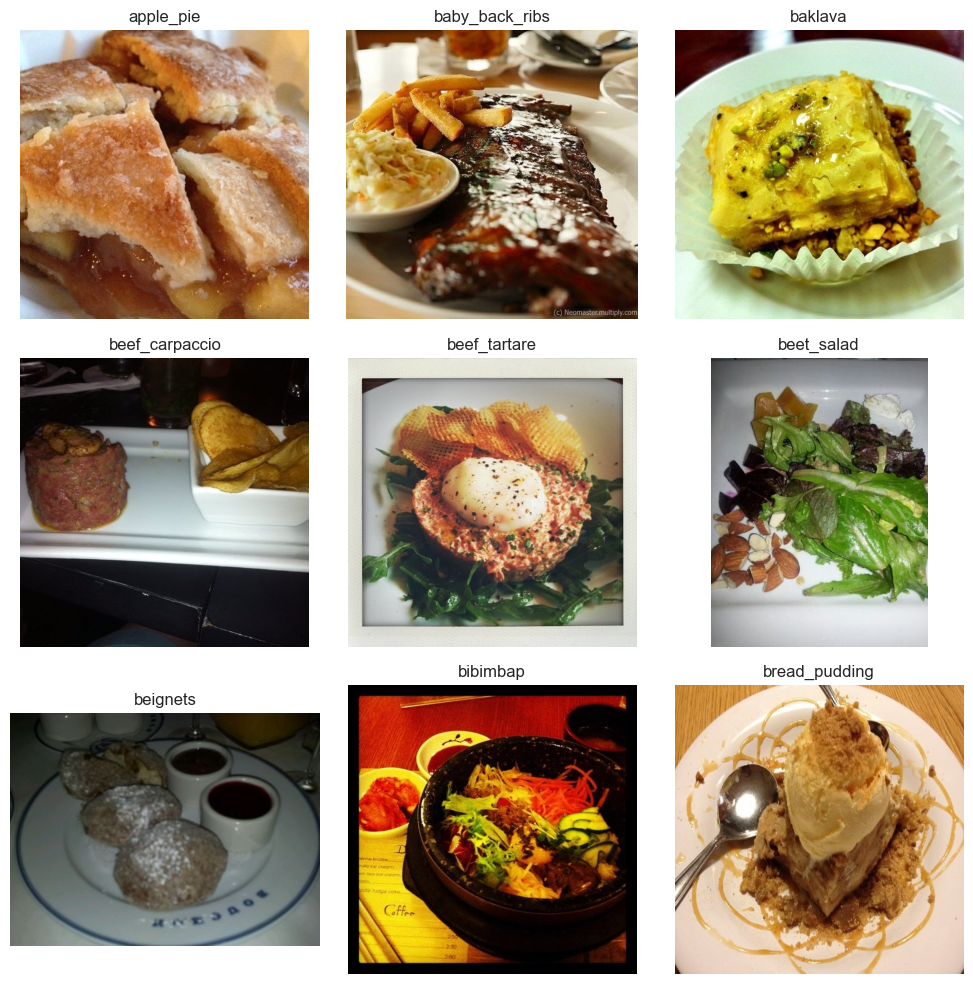

In [10]:
# Load a random sample of images from different categories
sample_images = train.groupby('category').apply(lambda x: x.sample(1))
sample_images_paths = []
for _, row in sample_images.iterrows():
    category = row['category']
    image_path = row['path']
    #image_path = f'{directory}/images/{category}/{filename}'
    sample_images_paths.append(image_path)

plt.figure(figsize=(10, 10))
num_images = min(len(sample_images_paths), 9)
num_rows = num_cols = int(num_images ** 0.5)
for i, image_path in enumerate(sample_images_paths[:num_images]):
    plt.subplot(num_rows, num_cols, i+1)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    plt.imshow(image)  # Display the image
    plt.title(sample_images.iloc[i]['category'])
    plt.axis('off')
plt.tight_layout()
plt.show()

### Observe images from apple pie category

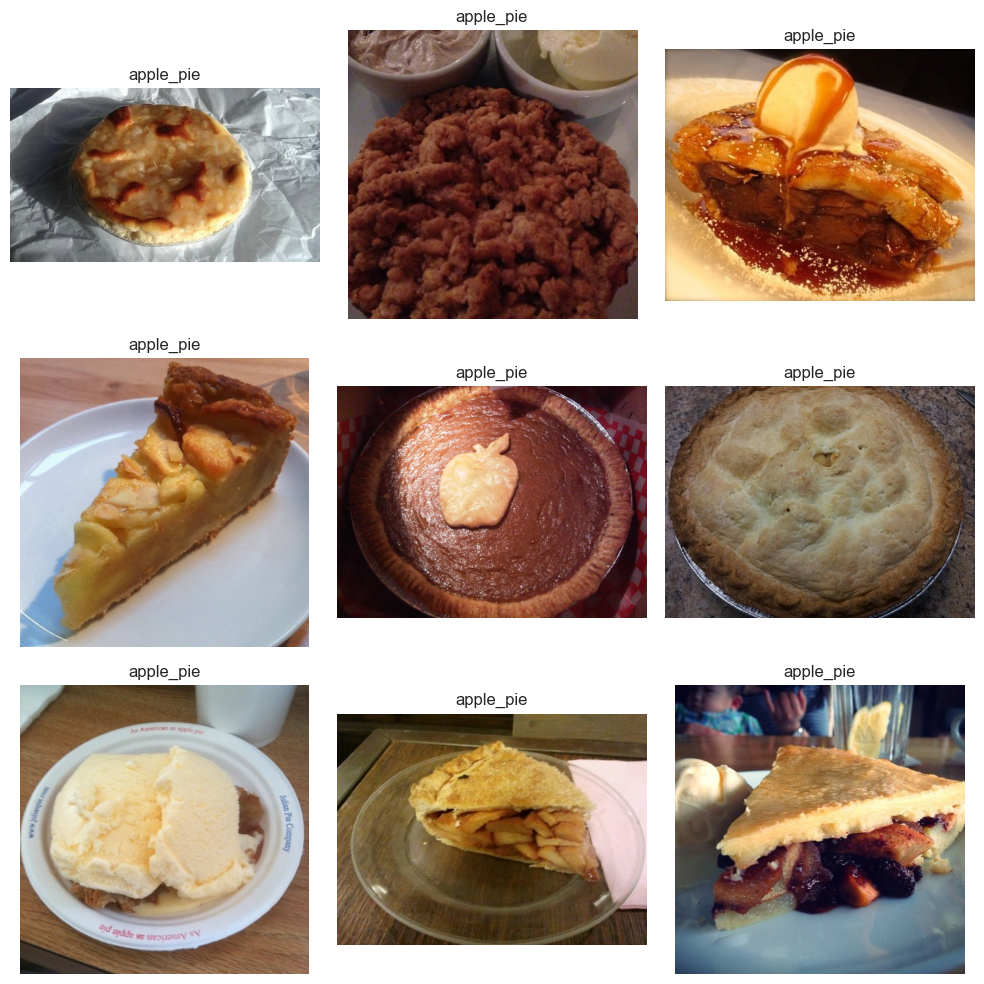

In [11]:
# Specify the category you want to plot
category_to_plot = "apple_pie"

# Filter the train_data based on the specified category
category_data = train[train['category'] == category_to_plot]

plt.figure(figsize=(10, 10))
num_images = min(len(category_data), 9)
num_rows = num_cols = int(num_images ** 0.5)
for i in range(num_images):
    plt.subplot(num_rows, num_cols, i+1)
    image_path = category_data.iloc[i]['path']
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    plt.imshow(image)  # Display the image
    plt.title(category_to_plot)
    plt.axis('off')
plt.tight_layout()
plt.show()

## EDA

### Explore the distribution of image size

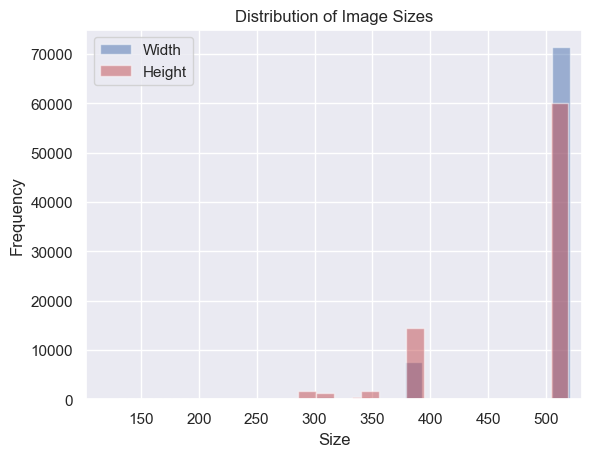

In [12]:
# Distribution of image sizes
image_sizes = []
for image_path in train['path']:
    image = cv2.imread(image_path)
    height, width, _ = image.shape
    image_sizes.append((width, height))
    
#plot the distribution
widths, heights = zip(*image_sizes)
plt.hist(widths, bins=50, alpha=0.5, color='b', label='Width', width=15)
plt.hist(heights, bins=50, alpha=0.5, color='r', label='Height', width=15)
plt.xlabel('Size')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Image Sizes')
plt.show()

 --> Most images have high values of height and width around 525 pixels, another size shows the next high frequency is around 375 pixels.

### Explore the distribution of mean intesity and contrast of the categories

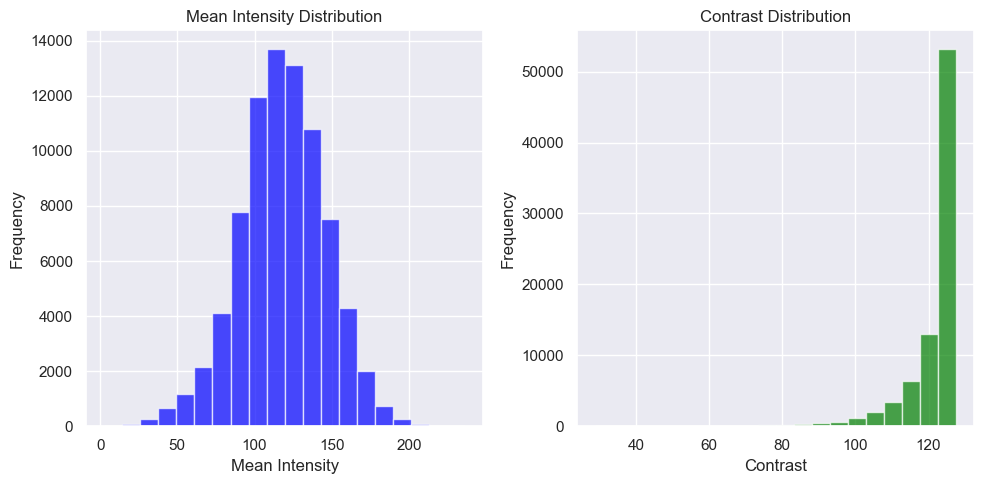

In [13]:
# Compute the mean intensity and contrast of images in the train_data dataset
mean_intensities = []
contrasts = []

for _, row in train.iterrows():
    image_path = row['path']
    
    # Load the image
    image = cv2.imread(image_path)
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Compute the mean intensity
    mean_intensity = np.mean(gray)
    mean_intensities.append(mean_intensity)
    
    # Compute the contrast
    _, thresholded = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contrast = np.std(thresholded)
    contrasts.append(contrast)

# Plot the mean intensity and contrast
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(mean_intensities, bins=20, color='blue', alpha=0.7)
plt.title('Mean Intensity Distribution')
plt.xlabel('Mean Intensity')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(contrasts, bins=20, color='green', alpha=0.7)
plt.title('Contrast Distribution')
plt.xlabel('Contrast')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

-->The mean intensity shows normal distribution of all images while contrast shows left skew distribution

### Explore the distribution of mean intesity and contrast values  for random 5 categories

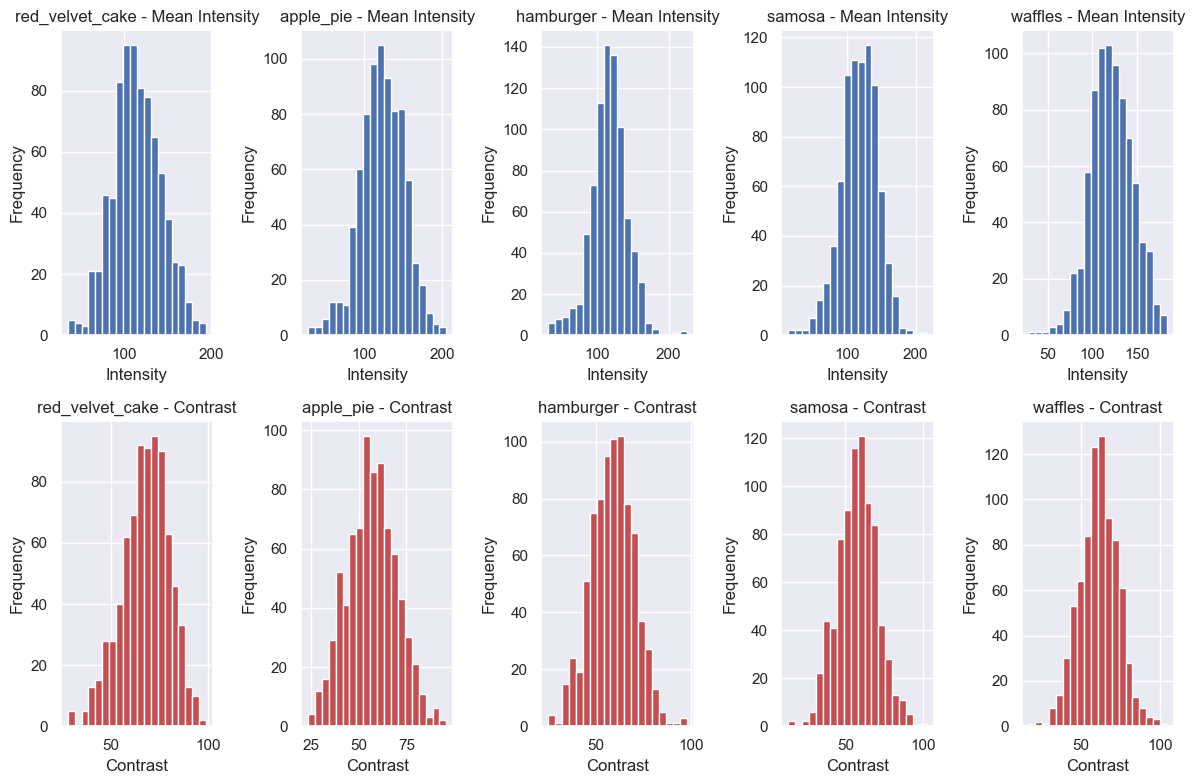

In [16]:
# Randomly select a subset of categories
num_categories = 5  
selected_categories = random.sample(labels, num_categories)

# Calculate and plot intensity and contrast for each category
plt.figure(figsize=(12, 8))
for i, category in enumerate(selected_categories):
    category_data = train[train['category'] == category]
    image_paths = category_data['path'].tolist()
    
    mean_intensities = []
    contrasts = []
    for image_path in image_paths:
        image = cv2.imread(image_path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        intensity = np.mean(gray) 
        contrast = np.std(gray) 
        mean_intensities.append(intensity)
        contrasts.append(contrast)
        
    plt.subplot(2, num_categories, i + 1)
    plt.hist(mean_intensities, bins=20, color='b')
    plt.title(f'{category} - Mean Intensity')
    plt.xlabel('Intensity')
    plt.ylabel('Frequency')

    plt.subplot(2, num_categories, num_categories + i + 1)
    plt.hist(contrasts, bins=20, color='r')
    plt.title(f'{category} - Contrast')
    plt.xlabel('Contrast')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

 --> The distribution of mean intensity and contrast in each category selected randomly show normal or close to normal ditribution. 

### Explore the texture of the images from each category

In [17]:
    
# Function to compute Haralick texture features for an image
def compute_haralick_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick = texture.haralick(gray)
    features = haralick.mean(axis=0)
    return features

# Analyze texture features for each category
texture_features = []
for category in labels:
    category_data = train[train['category'] == category]
    image_paths = category_data['path'].tolist()
    
    for image_path in image_paths:
        image = cv2.imread(image_path)
        features = compute_haralick_features(image)
        texture_features.append(features)

ModuleNotFoundError: No module named 'mahotas'

In [ ]:
texture_features[:5]

[array([ 2.27251333e-03,  3.07635366e+01,  9.95814211e-01,  3.67431964e+03,
         3.94909046e-01,  1.11782674e+02,  1.46665150e+04,  7.95808344e+00,
         1.06112610e+01,  6.79758918e-04,  3.09747636e+00, -4.80724093e-01,
         9.99343854e-01]),
 array([ 9.43849465e-04,  1.04702480e+02,  9.91193379e-01,  5.94642752e+03,
         3.14103474e-01,  3.16739700e+02,  2.36810076e+04,  8.64456541e+00,
         1.20029783e+01,  4.18382663e-04,  3.86048744e+00, -4.33352861e-01,
         9.99287761e-01]),
 array([ 7.55053021e-04,  3.06645758e+01,  9.91659391e-01,  1.83854640e+03,
         3.50513916e-01,  2.29684804e+02,  7.32352103e+03,  8.36092246e+00,
         1.13496460e+01,  5.81504336e-04,  3.23544983e+00, -4.59233162e-01,
         9.99356139e-01]),
 array([ 2.30069281e-04,  2.43026719e+02,  9.52853648e-01,  2.57741574e+03,
         2.03567896e-01,  2.73930298e+02,  1.00666362e+04,  8.62243368e+00,
         1.30248053e+01,  2.50714826e-04,  4.62530333e+00, -2.96022486e-01,
       

I ended up not getting this code segment to run. I think there must be a missing segment to create df_mean?

In [ ]:
# Observe texture feature distibution for some categories 
num_categories_to_plot = 6 

plt.figure(figsize=(15, 10))

for i, category in enumerate(df_mean.index[:num_categories_to_plot]):
    plt.subplot(2, 3, i+1)
    plt.bar(df_mean.columns, df_mean.loc[category])
    plt.title(f'{category} - Average Texture Feature Values')
    plt.xlabel('Texture Features')
    plt.ylabel('Average Feature Value')
    plt.xticks(rotation=45)

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()


Prominent features in the plot are:

Haralick Texture Feature 4: Sum of Squares Variance - It captures the variance of pixel intensities in the image.
Haralick Texture Feature 7: Sum Variance - It captures the variance of the sum values of local image regions.

--> The first 6 categories plots indicate distinct patterns and textures in the image and highlight contrast and variations in intensity or brightness

### Sample Data Augmentation

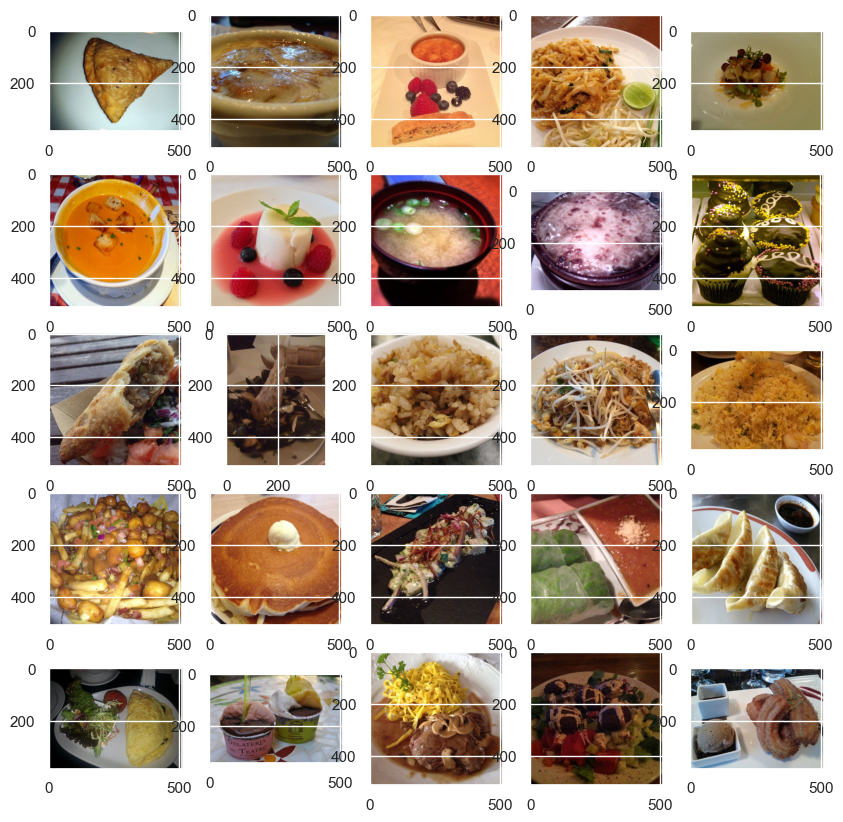

In [24]:
#plot the images
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
axes = ax.flatten()
for i in range(25):
    path=train['path'].iloc[i]
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img, cmap=None)


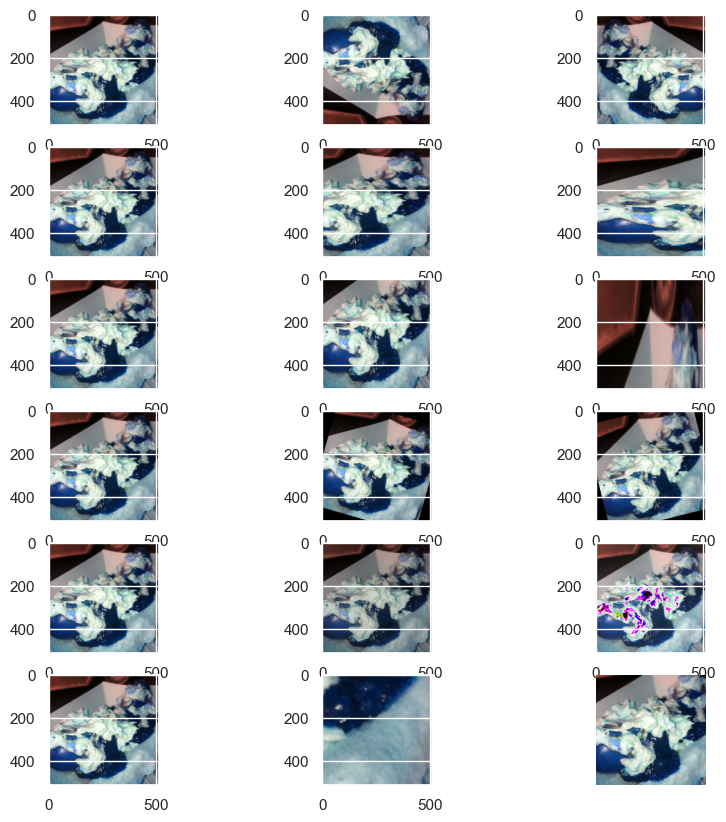

In [25]:
img = cv2.imread(train['path'].iloc[90])
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(10, 10))
axes = ax.flatten()

# Flipping Image
axes[0].imshow(img)
axes[1].imshow(aug.vertical_flip(img,True))
axes[2].imshow(aug.horizontal_flip(img,True))

# Horizontal Shifting Image
axes[3].imshow(img)
axes[4].imshow(aug.horizontal_shift(img,0.5))
axes[5].imshow(aug.horizontal_shift(img,0.9))

# Vertical Shifting Image
axes[6].imshow(img)
axes[7].imshow(aug.vertical_shift(img,0.5))
axes[8].imshow(aug.vertical_shift(img,0.9))

# Rotating Image
axes[9].imshow(img)
axes[10].imshow(aug.rotation(img,45))
axes[11].imshow(aug.rotation(img,90))

# Recolor Image
axes[12].imshow(img)
axes[13].imshow(aug.brightness(img,0.3,2))
axes[14].imshow(aug.channel_shift(img,90))

# Zoom Image
axes[15].imshow(img)
axes[16].imshow(aug.zoom(img,0.2))
axes[17].imshow(aug.zoom(img,0.6))

plt.axis('off')
plt.show()

## Creating datasets for modeling training and testing

In [120]:
di = "/Users/whitm/.fastai/data/food-101/splits/train/"
test_di = '/Users/whitm/.fastai/data/food-101/splits/test/'

In [126]:
ds_train = tf.keras.utils.image_dataset_from_directory(di, label_mode='categorical', labels='inferred',
                                                        batch_size=32, image_size=[224,224], shuffle=True, 
                                                        seed=123)

Found 80800 files belonging to 101 classes.


In [127]:
ds_val = tf.keras.utils.image_dataset_from_directory(test_di, label_mode='categorical', labels='inferred',
                                                        batch_size=32, image_size=[224,224], shuffle=True, 
                                                        seed=123,)

Found 20200 files belonging to 101 classes.


I ended up augmenting with tf rather than Ivan's augmentation. I struggled to load models appropriately when using the other augmentation techiniques in a similar way. Perhaps I am using them wrong. 

In [128]:
def augment(x, y):
    image = tf.image.resize(x, [224,224])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, 0.5)
    image = tf.image.random_contrast(image, 0.2, 0.7)
    image = tf.image.random_hue(image, 0.5)
    image = tf.image.random_saturation(image, 0.1, 0.7)
    return image, y

In [129]:
aug_ds_train = ds_train.map(augment)

## ResNet 34

In [130]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides = 1, activation = 'relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv2D(filters, 3, strides = strides,
                                padding = 'same', use_bias = False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, 3, strides = 1,
                                padding = 'same', use_bias = False),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides = strides,
                                    padding = 'same', use_bias = False),
                keras.layers.BatchNormalization()]

In [131]:
def call(self, inputs):
    Z = inputs
    for layer in self.main_layers:
        Z = layer(Z)
    skip_Z = inputs
    for layer in self.skip_layers:
        skip_Z = layer(skip_Z)
    return self.activation(Z + skip_Z)

In [132]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, 7, strides = 2, input_shape=[224, 224, 3],
                              padding = 'same', use_bias = False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPool2D(pool_size = 3, strides = 2, padding = 'same'))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides  = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides = strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(101, activation = 'softmax'))

In [133]:
model.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate = 0.001), metrics = ['categorical_accuracy'])

So far, trying to reach a high training accuracy on the ResNet 34 has been unsuccessful as it is a more shallow version of the ResNet.  

In [134]:
model.fit(aug_ds_train, epochs = 50, batch_size = 32)

Epoch 1/50
2525/2525 [==============================] - 435s 172ms/step - loss: 4.6037 - categorical_accuracy: 0.0142
Epoch 2/50
2525/2525 [==============================] - 386s 153ms/step - loss: 4.5747 - categorical_accuracy: 0.0183
Epoch 3/50
2525/2525 [==============================] - 371s 147ms/step - loss: 4.5486 - categorical_accuracy: 0.0223
Epoch 4/50
2525/2525 [==============================] - 372s 147ms/step - loss: 4.5281 - categorical_accuracy: 0.0244
Epoch 5/50
2525/2525 [==============================] - 363s 144ms/step - loss: 4.5107 - categorical_accuracy: 0.0273
Epoch 6/50
2525/2525 [==============================] - 358s 142ms/step - loss: 4.4973 - categorical_accuracy: 0.0300
Epoch 7/50
2463/2525 [============================>.] - ETA: 8s - loss: 4.4870 - categorical_accuracy: 0.0308

KeyboardInterrupt: 

## ResNet50

In [135]:
res = keras.applications.resnet50.ResNet50(weights=None, include_top = False, input_shape=(224,224,3))
x = res.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.7)(x)
predictions = keras.layers.Dense(101, activation = 'softmax')(x)
mod = keras.Model(inputs = res.input, outputs = predictions)

In [136]:
mod.compile(loss = [keras.losses.CategoricalCrossentropy(from_logits=True)], optimizer = keras.optimizers.Adam(learning_rate = 0.001), metrics = ['categorical_accuracy'])

I stopped this at nearly 300 minutes to just share some of the results

In [137]:
mod.fit(aug_ds_train, epochs = 35, batch_size = 64)

Epoch 1/35
2525/2525 [==============================] - 828s 324ms/step - loss: 4.7601 - categorical_accuracy: 0.0152
Epoch 2/35
2525/2525 [==============================] - 807s 320ms/step - loss: 4.5905 - categorical_accuracy: 0.0210
Epoch 3/35
2525/2525 [==============================] - 816s 323ms/step - loss: 4.4384 - categorical_accuracy: 0.0355
Epoch 4/35
2525/2525 [==============================] - 807s 320ms/step - loss: 4.2898 - categorical_accuracy: 0.0509
Epoch 5/35
2525/2525 [==============================] - 804s 318ms/step - loss: 4.1848 - categorical_accuracy: 0.0633
Epoch 6/35
2525/2525 [==============================] - 794s 315ms/step - loss: 4.0631 - categorical_accuracy: 0.0807
Epoch 7/35
2525/2525 [==============================] - 796s 315ms/step - loss: 3.8955 - categorical_accuracy: 0.1059
Epoch 8/35
2525/2525 [==============================] - 799s 316ms/step - loss: 3.7264 - categorical_accuracy: 0.1321
Epoch 9/35
2525/2525 [==============================] - 

KeyboardInterrupt: 

## MobileNet

In [88]:
mobile = keras.applications.MobileNet(weights=None, include_top = False, input_shape=(224,224,3))
x = mobile.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.7)(x)
predictions = keras.layers.Dense(101, activation = 'softmax')(x)
mob = keras.Model(inputs = mobile.input, outputs = predictions)

In [89]:
mob.compile(loss = [keras.losses.CategoricalCrossentropy(from_logits=True)], optimizer = keras.optimizers.Adam(learning_rate = 0.001), metrics = ['categorical_accuracy'])

I will try to run 50 epochs tomorrow to see the results.

In [91]:
mob.fit(aug_ds_train, epochs = 50, batch_size = 32)

Epoch 1/20
2525/2525 [==============================] - 533s 211ms/step - loss: 4.4389 - categorical_accuracy: 0.0347
Epoch 2/20
2525/2525 [==============================] - 534s 211ms/step - loss: 4.1547 - categorical_accuracy: 0.0673
Epoch 3/20
2525/2525 [==============================] - 633s 251ms/step - loss: 3.8284 - categorical_accuracy: 0.1132
Epoch 4/20
2525/2525 [==============================] - 586s 232ms/step - loss: 3.5017 - categorical_accuracy: 0.1722
Epoch 5/20
2525/2525 [==============================] - 538s 213ms/step - loss: 3.2197 - categorical_accuracy: 0.2249
Epoch 6/20
2525/2525 [==============================] - 518s 205ms/step - loss: 3.0005 - categorical_accuracy: 0.2710
Epoch 7/20
2525/2525 [==============================] - 520s 206ms/step - loss: 2.8180 - categorical_accuracy: 0.3062
Epoch 8/20
2525/2525 [==============================] - 527s 209ms/step - loss: 2.6628 - categorical_accuracy: 0.3414
Epoch 9/20
2525/2525 [==============================] - 

I am still looking at model evaluation

In [139]:
preds = mob.predict(ds_val)

632/632 [==============================] - 23s 36ms/step


In [152]:
# lists probability for each class
print(len(preds[0]))
print(max(preds[0]))
np.where(preds[0] == preds[0].max())

101
0.98942137


(array([100], dtype=int64),)

In [149]:
preds[0]

array([2.16317101e-04, 2.39034071e-05, 3.64091352e-06, 2.73341066e-05,
       1.23030509e-06, 1.68927636e-05, 3.13155965e-06, 1.94753625e-06,
       1.21921839e-04, 1.29641685e-05, 5.03054762e-05, 6.29479587e-07,
       1.42290420e-03, 1.76560454e-04, 1.54869103e-05, 2.27365217e-06,
       1.21351218e-06, 7.86551682e-05, 7.78804315e-06, 8.46476360e-06,
       2.64963802e-07, 5.54276397e-04, 1.32471949e-04, 3.10059331e-05,
       6.02886075e-07, 1.27141817e-07, 7.94196978e-07, 3.78594923e-05,
       1.09342784e-06, 1.91648709e-04, 1.41584565e-06, 1.68117823e-03,
       1.81339237e-05, 2.05270183e-07, 2.24595510e-06, 1.24300102e-04,
       3.71132410e-05, 4.22688618e-06, 5.53429587e-08, 3.21256766e-06,
       1.09921370e-08, 3.11853591e-06, 8.63676483e-04, 2.71427098e-07,
       3.89530243e-07, 5.91323578e-06, 7.22313359e-07, 8.38544474e-06,
       6.75864931e-06, 1.02562592e-06, 5.45686726e-06, 7.43863097e-07,
       6.86413978e-06, 3.48803746e-06, 2.70152555e-06, 4.78955080e-05,
      

In [163]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in ds_val:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = mob.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)


1/1 [==============================] - 1s 1s/step


In [170]:
correct_labels

<tf.Tensor: shape=(20200, 101), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [171]:
predicted_labels

<tf.Tensor: shape=(20200,), dtype=int64, numpy=array([73, 30, 35, ..., 63, 53, 54], dtype=int64)>